In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "128"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import matplotlib.pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
from utility import bin_cell
from os.path import join as opj

import healpy as hp
import numpy as np

# Finally, synfast will build a realization of the lensed maps for you from scratch
from lenspyx import synfast
from lenspyx.utils import camb_clfile

import plancklens
from plancklens.filt import filt_simple, filt_util
from plancklens import utils
from plancklens import qest, qecl, qresp
from plancklens import nhl
from plancklens.n1 import n1
# from plancklens.sims import planck2018_sims, phas, maps, utils as maps_utils

from plancklens.utils import clhash, hash_check

import pysm3 
import pysm3.units as u

from common import convert_units

# sns.reset_defaults()

# from shutil import rmtree

In [3]:
import time

In [4]:
cls_path = '/global/homes/j/jianyao/non_gau_lensing/theory/cls/'

# simulation class

In [5]:
class cmb_len(object):

    def __init__(self, add_foreground, from_fg_res = False):
        
        if add_foreground != 'no_fore':

            dir_cleaned_cmb = '/pscratch/sd/j/jianyao/data_lensing/simulations/cleaned_CMB/SO_LAT/' # SO LAT
            
            # get an estimation of lensing field from foreground residuals: to test the estimator response to the fg_res
            if from_fg_res: 
                print('load fg_res')
                self.alms = dir_cleaned_cmb + 'FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024'%(add_foreground)
                
            else:
                self.alms = dir_cleaned_cmb + 'CMB_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024'%(add_foreground)
        
        elif add_foreground == 'no_fore':
            
            dir_cleaned_cmb = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb_noise_only/SO_LAT_145GHz/'
            self.alms = dir_cleaned_cmb + 'CMB_noise_alms_from_SO_LAT_145GHz_%s_nside_1024'%(add_foreground)
        # self.dirs = os.environ["data"] + 'cmb_plus_%s'%self.add_foreground
        
    def hashdict(self):
        return {'sim_lib': 'ffp10 lensed scalar cmb inputs, freq 0'}

    # @staticmethod
    def get_sim_tlm(self, idx):
        
        # return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=1)
        
        alms = self.alms + '_%04d.fits'%idx
        # print(alms)
        return hp.read_alm(alms, hdu = 1)
    
    # @staticmethod
    def get_sim_elm(self, idx):

        # return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=2)
        
        alms = self.alms + '_%04d.fits'%idx
        # print(alms)
        return hp.read_alm(alms, hdu = 2)

    # @staticmethod
    def get_sim_blm(self, idx):

        # return hp.read_alm(opj(self.dirs, 'lensed_scl_cmb_plus_%s_alm_mc_%04d.fits'%(self.add_foreground, idx)), hdu=3)
        
        alms = self.alms + '_%04d.fits'%idx
        # print(alms)
        return hp.read_alm(alms, hdu = 3)
    
    
class cmb_noise(object):
    r"""CMB simulation library combining a lensed CMB library and a transfer function.

        Args:
            sims_cmb_len: lensed CMB library (e.g. *plancklens.sims.planck2018_sims.cmb_len_ffp10*)
            cl_transf: CMB temperature transfer function
            nside: healpy resolution of the maps. Defaults to 2048.
            lib_dir(optional): hash checks will be cached, as well as possibly other things for subclasses.
            cl_transf_P: CMB pol transfer function (if different from cl_transf)\
            eff_beam: fwhm; None or a number; if a number, apply the beam of this level to the input cleaned CMB map

    """
    def __init__(self, sims_cmb_len, cl_transf, nlev_t, nlev_p, nside=2048, cl_transf_P=None, lib_dir=None):
        if cl_transf_P is None:
            cl_transf_P = np.copy(cl_transf)

        self.sims_cmb_len = sims_cmb_len
        self.cl_transf_T = cl_transf
        self.cl_transf_P = cl_transf_P
        self.nside = nside
        self.nlev_t = nlev_t
        self.nlev_p = nlev_p
        self.vamin = np.sqrt(hp.nside2pixarea(self.nside, degrees=True)) * 60

        if lib_dir is not None:
            fn_hash = os.path.join(lib_dir, 'sim_hash.pk')
            if mpi.rank == 0 and not os.path.exists(fn_hash):
                pk.dump(self.hashdict(), open(fn_hash, 'wb'), protocol=2)
            mpi.barrier()
            hash_check(self.hashdict(), pk.load(open(fn_hash, 'rb')), fn=fn_hash)

    def hashdict(self):
        ret = {'sims_cmb_len':self.sims_cmb_len.hashdict(),'nside':self.nside,'cl_transf':clhash(self.cl_transf_T)}
        if not (np.all(self.cl_transf_P == self.cl_transf_T)):
            ret['cl_transf_P'] = clhash(self.cl_transf_P)
        return ret

    def get_sim_tmap(self,idx):
        """Returns temperature healpy map for a simulation

            Args:
                idx: simulation index

            Returns:
                healpy map

        """
        tlm = self.sims_cmb_len.get_sim_tlm(idx)
        # hp.almxfl(tlm,self.cl_transf_T,inplace=True)
        tmap = hp.alm2map(tlm,self.nside)
        return tmap + self.get_sim_tnoise(idx)

    def get_sim_pmap(self,idx):
        """Returns polarization healpy maps for a simulation

            Args:
                idx: simulation index

            Returns:
                Q and U healpy maps

        """
        elm = self.sims_cmb_len.get_sim_elm(idx)
        blm = self.sims_cmb_len.get_sim_blm(idx)
        
        if self.cl_transf_T[-1] != 1:
            # in the case of apply the effective beam to the input cleaned CMB map
            hp.almxfl(elm,self.cl_transf_P,inplace=True)
            hp.almxfl(blm, self.cl_transf_P, inplace=True)
        Q,U = hp.alm2map_spin([elm,blm], self.nside, 2,hp.Alm.getlmax(elm.size))
        del elm,blm
        return Q + self.get_sim_qnoise(idx),U + self.get_sim_unoise(idx)

    def get_sim_tnoise(self,idx):
        '''
        there are already noise in the clean CMB maps
        '''
        return 0 #self.nlev_t / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[0] # one frequency for now 11.15

    def get_sim_qnoise(self, idx):
        
        return 0 #self.nlev_p / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[1]

    def get_sim_unoise(self, idx):
        
        return 0 #self.nlev_p / self.vamin * np.load(opj(os.environ["data"],'noise/noise_1uK_amin_map_mc_%04d.npy'%idx))[2]

# apply plancklens

In [6]:
#--- definition of simulation and inverse-variance filtered simulation libraries:
# lmax_ivf = 2048
# lmin_ivf = 100  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
# lmax_qlm = 2048 # We will calculate lensing estimates until multipole lmax_qlm.; 4096
nside = 1024 # Healpix resolution of the data and sims.; 2048

# nsims = 300  # Total number of simulations to consider.

In [7]:
cl_unl = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
#: Fiducial unlensed and lensed power spectra used for the analysis.

cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.
#: CMB spectra entering the QE weights (the spectra multplying the inverse-variance filtered maps in the QE legs) 

## define function

In [ ]:
class lenre():
    
    def __init__(self, ):
        
        pass
    
    def run_qe(self, ):

    
    def plot(self, ):
    

In [19]:
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7

def run_qe(qe_keys, cases, lmin_ivf, lmax_ivf, lmax_qlm, nsim = 1, lmax_Bmode = None, mf = None, old_dir = False, from_fg_res = False, which_fg = None, compare_mf = False):
    '''
    Parameters
    ----------
    
    qe_keys: ['p_eb']; one key for now; 20240112
    lmax_Bmode: used to set fbl[lmax_Bmode:] = 0 to avoid the foreground residual in the B modes. for the estimator key p_p;
    return_results: Bool
                    return all the results inside a list
                    

    old_dir: If True, dir will be named without lmin and lmax;
    nsim: return many realizations of qlm if lager than 1, which can be used to get errors.
    
    mf: cached mean field; can be mean field from other case.
    from_fg_res: test the lensing estimator response from fg_res
    which_fg: Bool; If True, use the bias from another kind of dust 
    compare_mf: Bool; In the case of fg_res, if True, also return the mean-field from 300 realizations
    '''
    
    transf = np.ones(lmax_ivf + 1)
    
    if lmax_Bmode is None:
        lmax_Bmode = lmax_ivf

    results_phi = []
    results_n0 = []
    results_mf = []
    ells_binned = []
        
    results_qlms = []
    results_qnorms = []
    
    results_phi_fg = []
    results_n0_fg = []
    results_qnorms_fg = []
    
    for add_foreground in cases:

        # plt.loglog(nl[2])

        nlev_t = 0; #2.16
        nlev_p = 0; #2.16
        qnorms = []
        nhl_datas = []
        qlms = []  

        if add_foreground != 'no_fore':
            dir_cleaned_cmb = '/pscratch/sd/j/jianyao/data_lensing/simulations/cleaned_CMB/SO_LAT/' # SO LAT
            nl_all = []
            for mc in range(100):
                noise_alm = hp.read_alm(dir_cleaned_cmb + 'Noise_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), hdu = [1, 2, 3])
                nl_all.append(hp.alm2cl(noise_alm, lmax =  lmax_ivf))
            nl_mean = np.mean(nl_all, axis = 0)
            # print(nl_mean.shape)

            ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + nl_mean[0]/transf**2) #(nlev_t / 60. / 180. * np.pi / transf) ** 2) # covariance 
            fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + nl_mean[1]/transf**2) #(nlev_p / 60. / 180. * np.pi / transf) ** 2)
            fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + nl_mean[2]/transf**2) #(nlev_p / 60. / 180. * np.pi / transf) ** 2)
            
            if old_dir:
                assert qe_keys[0] == 'p_eb', 'old_dir for p_eb'
                TEMP = '/pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/cleaned_cmb_%s'%(add_foreground)

            else:
                TEMP = '/pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/cleaned_cmb_%s_lmin_%s_lmax_%s_%s_lmax_Bmode_%s'%(add_foreground, lmin_ivf, lmax_ivf, qe_keys[0], lmax_Bmode)

        elif add_foreground == 'no_fore':
            dir_cleaned_cmb = '/pscratch/sd/j/jianyao/data_lensing/simulations/cmb_noise_only/SO_LAT_145GHz/'
            nlev_t = 10.0; nlev_p = 14.1; # for the case of SO_LAT 145GHz
            ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / transf) ** 2) # covariance 
            fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
            fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)

            TEMP = '/pscratch/sd/j/jianyao/data_lensing/lenre_results/SO_LAT/no_fore_lmin_%s_lmax_%s'%(lmin_ivf, lmax_ivf)
        
        ftl[:lmin_ivf] *= 0.
        fel[:lmin_ivf] *= 0.
        fbl[:lmin_ivf] *= 0.
        
        if lmax_Bmode != lmax_ivf:
            # assert qe_keys[0] == 'p_p', 'not using polarization estimator'
            fbl[lmax_Bmode:] *= 0.

        sims = cmb_noise(cmb_len(add_foreground=add_foreground), transf, nlev_t, nlev_p, nside)
        ivfs = filt_simple.library_fullsky_sepTP(os.path.join(TEMP, 'ivfs'), sims, nside, transf, cl_len, ftl, fel, fbl, cache=True)
        qlms_dd = qest.library_sepTP(os.path.join(TEMP, 'qlms_dd'), ivfs, ivfs, cl_len['te'], nside, lmax_qlm=lmax_qlm)
        nhl_dd = nhl.nhl_lib_simple(os.path.join(TEMP, 'nhl_dd'), ivfs, cl_weight, lmax_qlm)

        # for fg_res
        if from_fg_res:
            
            if which_fg is not None:
                TEMP_fg = TEMP + '/fg_%s_res'%which_fg  
                sims_fg = cmb_noise(cmb_len(add_foreground=which_fg, from_fg_res=from_fg_res), transf, nlev_t, nlev_p, nside)
            else:
                TEMP_fg = TEMP + '/fg_res'
                sims_fg = cmb_noise(cmb_len(add_foreground=add_foreground, from_fg_res=from_fg_res), transf, nlev_t, nlev_p, nside)
                
            fl_EE = hp.alm2cl(sims_fg.sims_cmb_len.get_sim_elm(0))
            fl_BB = hp.alm2cl(sims_fg.sims_cmb_len.get_sim_blm(0))
            fel_fg = utils.cli(fl_EE[:lmax_ivf + 1]); fel_fg[:lmin_ivf] *= 0.
            fbl_fg = utils.cli(fl_BB[:lmax_ivf + 1]); fbl_fg[:lmin_ivf] *= 0.
            ftl_fg = np.ones_like(fel_fg);            ftl_fg[:lmin_ivf] *= 0.
            fl_weight = {'tt':np.ones_like(fl_EE), 'ee':fl_EE, 'bb':fl_BB, 'te':np.ones_like(fl_EE)}
            
#             if lmax_Bmode != lmax_ivf:
#                 fbl_fg[lmax_Bmode:] *= 0.
                
            ftl_fg = ftl
            fel_fg = fel
            fbl_fg = fbl
            fl_len = cl_len
            # fl_weight = cl_weight #N0 bias for fg_res should consider Fl,  which are included in ivfs_fg
            
            ivfs_fg = filt_simple.library_fullsky_sepTP(os.path.join(TEMP_fg, 'ivfs'), sims_fg, nside, transf, fl_len, ftl_fg, fel_fg, fbl_fg, cache=True)
            qlms_dd_fg = qest.library_sepTP(os.path.join(TEMP_fg, 'qlms_dd'), ivfs_fg, ivfs_fg, fl_len['te'], nside, lmax_qlm=lmax_qlm)
            nhl_dd_fg = nhl.nhl_lib_simple(os.path.join(TEMP_fg, 'nhl_dd'), ivfs_fg, fl_weight, lmax_qlm)
            
            qlm_fg = qlms_dd_fg.get_sim_qlm(qe_keys[0], 0)
            nhl_data_fg = nhl_dd_fg.get_sim_nhl(0, qe_keys[0], qe_keys[0])
        
        #---- N1 lensing bias library:
        # libdir_n1_dd = os.path.join(TEMP, 'n1_test')
        # n1_dd = n1.library_n1(libdir_n1_dd,cl_len['tt'],cl_len['te'],cl_len['ee'])

        #---- QE response calculation library:
        qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp'), lmax_ivf, cl_weight, cl_len,
                                         {'t': ivfs.get_ftl(), 'e':ivfs.get_fel(), 'b':ivfs.get_fbl()}, lmax_qlm)

        for mc in range(nsim):

            for qe_key in qe_keys:
                
            #     # This loads the estimate calculated in the previous cell:
                qlm = qlms_dd.get_sim_qlm(qe_key, mc)
                
            #     # Semi-analytical realization-dependent Gaussian noise bias (of the unnormalized estimator):
                nhl_data = nhl_dd.get_sim_nhl(mc, qe_key, qe_key)

                qlms.append(qlm)
                nhl_datas.append(nhl_data)

                if mc == 0:
                    # Lensing response according to the fiducial cosmology:
                    qresp_dat = qresp_dd.get_response(qe_key, 'p')
                    # Estimator normalization is the inverse response:
                    qnorm = utils.cli(qresp_dat)
                    qnorms.append(qnorm)    
                    
        ell = np.arange(2 if qe_key[0] == 'x' else 2, lmax_qlm) # qnorms has very large number for \ell = 1; 2023/12/26
       
        # qlm_mean = np.mean(qlms[1:], axis = 0)

        # ## check Gaussian!!!
        # qlm_mean = 0
        # qlms_mf_300 = 0
        
        if from_fg_res: # in this case, no mean field is estimated
            
            qlms_mf_300 = np.zeros_like(qlm, dtype= np.complex128)
            
        else:
            
            if mf: # use cached mean field estimate
                print('use mf %s'%mf)
                qlms_mf_300 = hp.read_alm(mf)

            elif nsim == 1:
                qlms_mf_300 = qlms_dd.get_sim_qlm_mf(qe_keys[0], np.arange(1, 300)) # consider only one key!! 2024-01-12

            else: 
                qlms_mf_300 = np.mean(qlms[1:], axis = 0)


        n0 = nhl_data[ell] * qnorm[ell] ** 2 * w(ell)
        mf = hp.alm2cl(qlms_mf_300)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell)
        cleaned = (hp.alm2cl(qlms[0] - qlms_mf_300)[ell] - nhl_data[ell])* qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell)
        # cleaned = ((hp.alm2cl(qlms[0]) - hp.alm2cl(qlms_mf_300))[ell] - nhl_data[ell])* qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell)
        
        if from_fg_res:
            
            if compare_mf: ## get mf for CMB 
                qlms_mf_300 = qlms_dd.get_sim_qlm_mf(qe_keys[0], np.arange(1, 400))
                mf = hp.alm2cl(qlms_mf_300)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell)
                cleaned_mf_alm = (hp.alm2cl(qlms[0] - qlms_mf_300)[ell] - nhl_data[ell])* qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell)
            
            # qresp_dd_fg = qresp.resp_lib_simple(os.path.join(TEMP_fg, 'qresp'), lmax_ivf, fl_len, fl_len, 
            #                                     {'t': ivfs_fg.get_ftl(), 'e':ivfs_fg.get_fel(), 'b':ivfs_fg.get_fbl()}, lmax_qlm)
            # qresp_dat_fg = qresp_dd_fg.get_response(qe_key[0], 'p')
            # qnorm_fg = utils.cli(qresp_dat_fg)
            
            qnorm_fg = qnorm
            print('using qnorm_cmb as qnorm_fg')
            
            n0_fg = nhl_data_fg[ell] * qnorm_fg[ell] ** 2 * w(ell)
            cleaned_fg = (hp.alm2cl(qlm_fg)[ell] - nhl_data_fg[ell])* qnorm_fg[ell] ** 2 / qlms_dd_fg.fsky12 * w(ell)
            
            results_n0_fg.append(n0_fg)
            results_phi_fg.append(cleaned_fg)
            results_qnorms_fg.append(qnorm_fg)
            
        results_phi.append(cleaned)
        results_mf.append(mf)
        results_n0.append(n0)
        ells_binned.append(ell)
        
        results_qlms.append(qlms)
        results_qnorms.append(qnorm)
        
    if len(cases) > 1:
        # to avoid list
        results_phi = cleaned
        results_mf = mf
        results_n0 = n0
        ells_binned = ell
        results_qlms = qlms
        results_qnorms = qnorm
    
    if nsim > 1:
        
        return ells_binned, results_phi, results_mf, results_n0, results_qlms, results_qnorms
    
    if from_fg_res:
        
        return ells_binned, results_phi, results_mf, results_n0, results_qnorms, results_phi_fg, results_n0_fg, results_qnorms_fg, [cleaned_mf_alm]
    
    return ells_binned, results_phi, results_mf, results_n0
    

### plot_lensing

In [11]:
def plot_lensing(lmax_qlm, results, return_binned = False, qe_key = 'p_p', add_foreground = 'd9', conf = 'lmin = 100', from_fg_res = False):
    
    '''
    lmax_qlm
    results: output from `run_qe`with nsim == 1
    ells, results_phi, results_mf, results_n0
    '''
    
    ells, results_phi, results_mf, results_n0 = results[0][0], results[1][0], results[2][0], results[3][0]
    
    bw = 10
    ell_binned, n0_binned =  bin_cell(results_n0, lmax = lmax_qlm, bins=bw, ell_2=False)
    _, cleaned_binned =  bin_cell(results_phi, lmax = lmax_qlm, bins=bw, ell_2=False)
    _, mf_binned =  bin_cell(results_mf, lmax = lmax_qlm, bins=bw, ell_2=False)
    
    _, cl_pp = bin_cell(cl_unl['pp'][ells] *  w(ells), lmax = lmax_qlm, bins=bw, ell_2=False)

    if from_fg_res:
        results_phi_fg = results[5][0]
        results_n0_fg = results[6][0]
        _, phi_fg_binned = bin_cell(results_phi_fg, lmax = lmax_qlm, bins=bw, ell_2=False)
        _, n0_fg_binned =  bin_cell(results_n0_fg, lmax = lmax_qlm, bins=bw, ell_2=False)
        
    if return_binned:
        ell_binned, cleaned_binned[0], mf_binned[0], n0_binned[0]
        
    plt.figure(figsize = (15, 6))
    # plt.title('%s for %s, lmin = %s, lmax = %s'%(qe_key, add_foreground, lmin_qlm, lmax_qlm))
    

    # label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
    plt.subplot(121)
    plt.title('%s for %s'%(qe_key, conf))
    plt.loglog(ell_binned, cl_pp[0], c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    plt.loglog(ell_binned, n0_binned[0], '--', label=r'$\hat N_L^{(0)}$')

    if np.mean(results_mf) == 0:
        plt.loglog(ell_binned, cleaned_binned[0], label = r'%s $- N_L^{(0)}$'%add_foreground)

    else:
        plt.loglog(ell_binned, mf_binned[0], label = 'mean_field')
        plt.loglog(ell_binned, cleaned_binned[0], label = r'%s $- N_L^{(0)}$'%add_foreground)
        
    if from_fg_res:
        
        plt.loglog(ell_binned, phi_fg_binned[0], label = r'%s fg res - $N_{L, fg}^{(0)}$'%add_foreground, ls = '--')
        plt.text(50, 1e-2, r'$N^{0}_{fg res} = %.1e$'%np.mean(n0_fg_binned[0]))
        # plt.loglog(ell_binned, n0_fg_binned[0], '--', label=r'$\hat N_{L, fg}^{(0)}$')
    plt.xlabel('$L$', fontsize=12)
    plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
    plt.ylim(1e-3,4e1)
    plt.xlim(3, )
    plt.legend(fontsize=12, loc='lower left', frameon = False)
    
    plt.subplot(122)
    plt.loglog(ell_binned, cl_pp[0], c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
    plt.loglog(ell_binned, cleaned_binned[0] - phi_fg_binned[0], 'r--', label = 'Left_Green - pp_fg_res')
    plt.loglog(ell_binned, cleaned_binned[0] - mf_binned[0], '--', label = 'Left_Green - cl_mf', color = sns.color_palette()[1])
    
    try:
        assert len(results) == 9, len(results)
        _, cleaned_mf_alm =  bin_cell(results[-1][0], lmax = lmax_qlm, bins=bw, ell_2=False)
        plt.loglog(ell_binned, cleaned_mf_alm[0], '--', label = 'Left_Green - alm_mf', color = sns.color_palette()[2])
    except:
        print('Not including cleaned phi with mf subtracted at alm level')
        
    plt.ylim(1e-3,4e1)
    plt.legend(fontsize=12, loc='lower left', frameon = False)

In [12]:
def Ell(ell_list):
    ell = np.array(ell_list)
    return ell*(ell+1)/2/np.pi

def bin_cell(cls, lmax, bins, ell_2 = True):
    '''
    cls: list; cls including several XX or for only one XX, X means T, E, B
    bins: an integer or a list; if list, determines the edges of the bins
    lmax:
    
    Return
    ------
    ells_bin: binned ells, don't include multipoles beyond the last bin_edge defined by N*bin_width
    cls_bin: binned cell
    ell_2: Bool; If True, factor ell*(ell+1)/2/np.pi are applied to the output binned cell.
    
    '''
    
    if isinstance(bins, list):
        use_edge = True
        N = len(bins) - 1
        
    else:
        use_edge = False
        N = lmax//bins
    
    if len(cls) != 6:
        cls = [cls]
        
    cls_bin = []
    for s in range(len(cls)):
        cls_bin_i = np.zeros(N)
        
        if s == 0:
            ells = np.arange(len(cls[0]))
            ells_bin = []
        
        for i in range(N):
            
            
            if use_edge:
                if s == 0:
                    ells_bin.append(np.mean(ells[bins[i]:bins[i+1]]))
                    
                cls_bin_i[i] = np.mean(cls[s][bins[i]:bins[i+1]])    
                
            else:
                if s == 0:
                    ells_bin.append(np.mean(ells[i*bins:(i+1)*bins]))
                    
                cls_bin_i[i] = np.mean(cls[s][i*bins:(i+1)*bins])
                
        if ell_2:
            cls_bin_i *= Ell(ells_bin)
        
        cls_bin.append(cls_bin_i)
    
    return ells_bin, cls_bin

In [13]:
def get_SNR(ells, cl_pp_input, n0_input, lmax):
    
    n0 = n0_input/w(ells) # input n0 is multiplied with the L^4 factor
    
    cl_pp = cl_pp_input[ells]
    snr2 = (cl_pp/(cl_pp + n0))**2*(ells + 0.5)
    # plt.loglog(snr2)
    return np.sqrt(sum(snr2[:lmax-2]))

In [14]:
def plot_snr(ells, cl_pp_input, results, labels):

    cl_pp = cl_pp_input[ells]
   
    lmaxs = np.arange(600, 1000, 20)
    
    for i in range(len(labels)):
        snrs = []
        n0 =  results[i]/w(ells)
        snr2 = (cl_pp/(cl_pp + n0))**2*(ells + 0.5)
        
        for lmax in lmaxs:
            snr_sum = np.sqrt(sum(snr2[:lmax-2]))
            
            snrs.append(snr_sum)
    
        plt.plot(lmaxs, snrs, label = labels[i])
    
    plt.legend()

## run function

## lensing estimator for foreground residuals

ells_binned, results_phi, results_mf, results_n0, results_qnorms, results_phi_fg, results_n0_fg, results_qnorms_fg#, [cleaned_mf_alm]

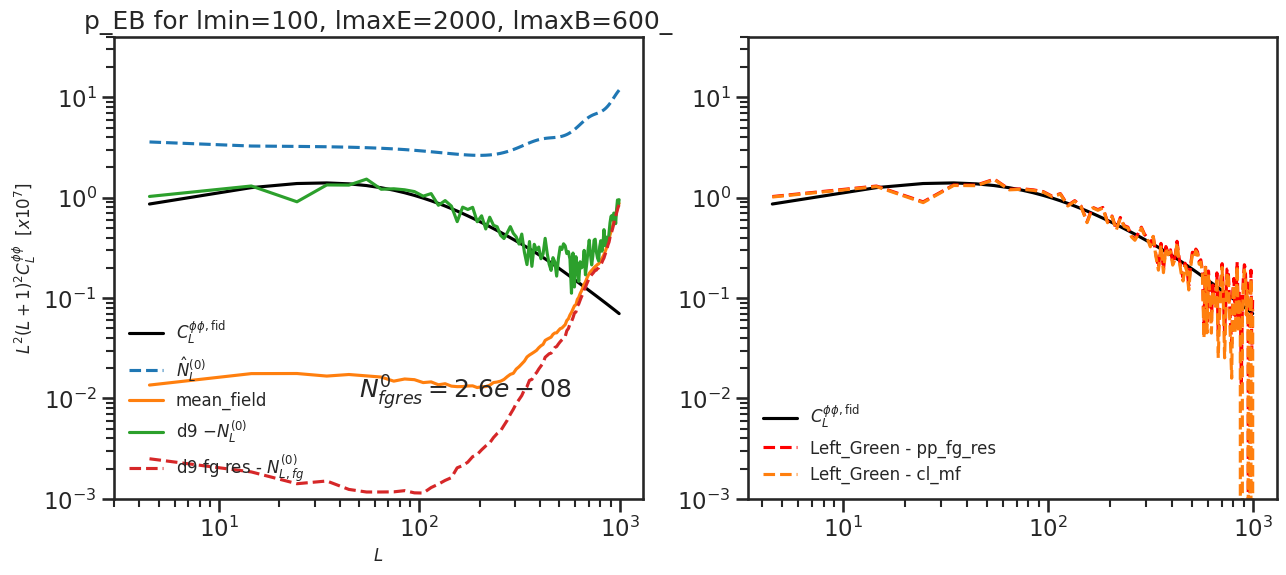

In [306]:
lmin_ivf = 100
lmax_ivf=2000
lmax_Bmode= 600

d9_res = run_qe(['p_eb'a], ['d9'], lmin_ivf = lmin_ivf, lmax_ivf=lmax_ivf, lmax_qlm = 1000, mf = None, nsim = 1, lmax_Bmode= lmax_Bmode, old_dir= False, from_fg_res=True, compare_mf=True)
plot_lensing(1000, d9_res, return_binned = False, qe_key = 'p_EB', add_foreground = 'd9', conf = 'lmin=%s, lmaxE=%s, lmaxB=%s_'%(lmin_ivf, lmax_ivf, lmax_Bmode), from_fg_res=True)

In [20]:
cases = ['forse3_Gaussiand9', 'd9', 'forse3_d9']
# cases = ['forse3_Gaussiand9', 'forse3_d9']

load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg
load fg_res
using qnorm_cmb as qnorm_fg


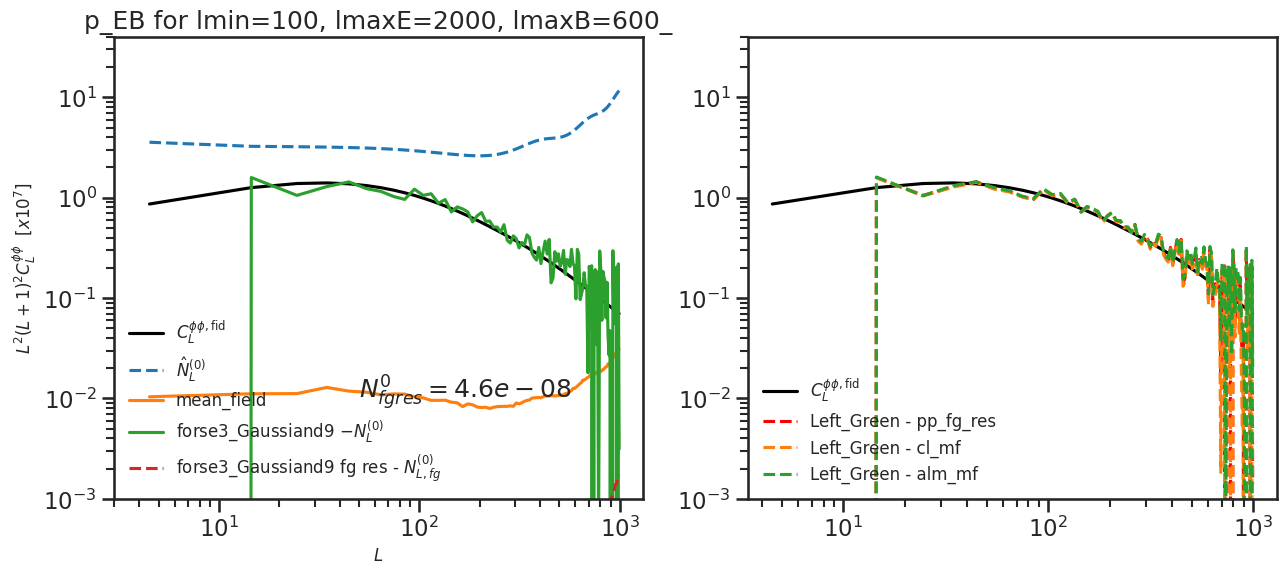

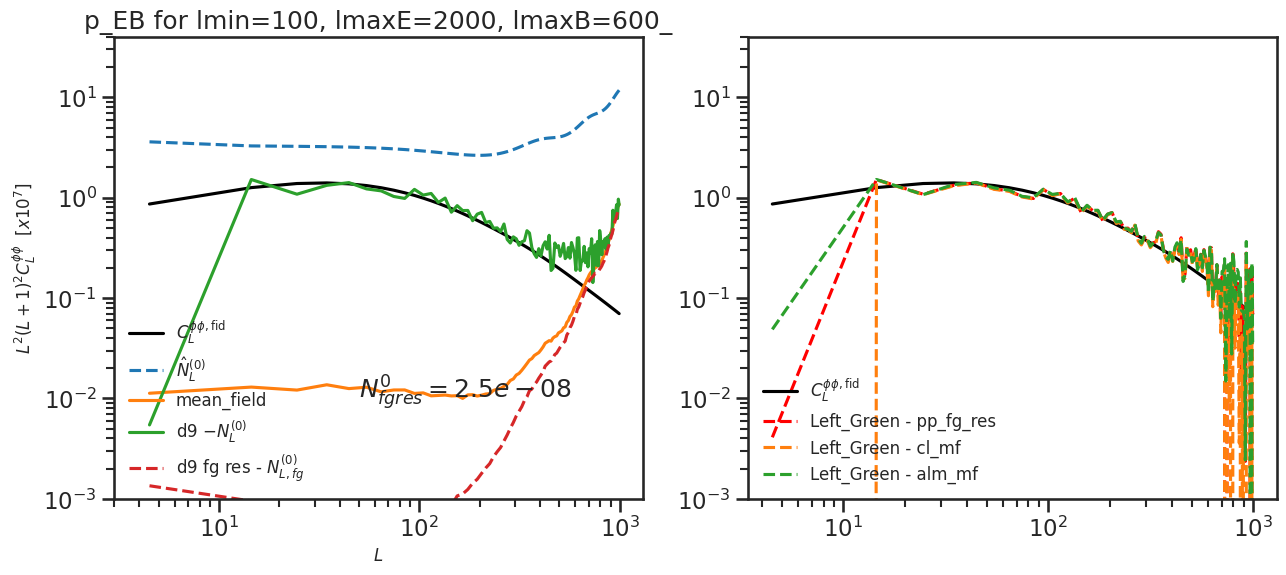

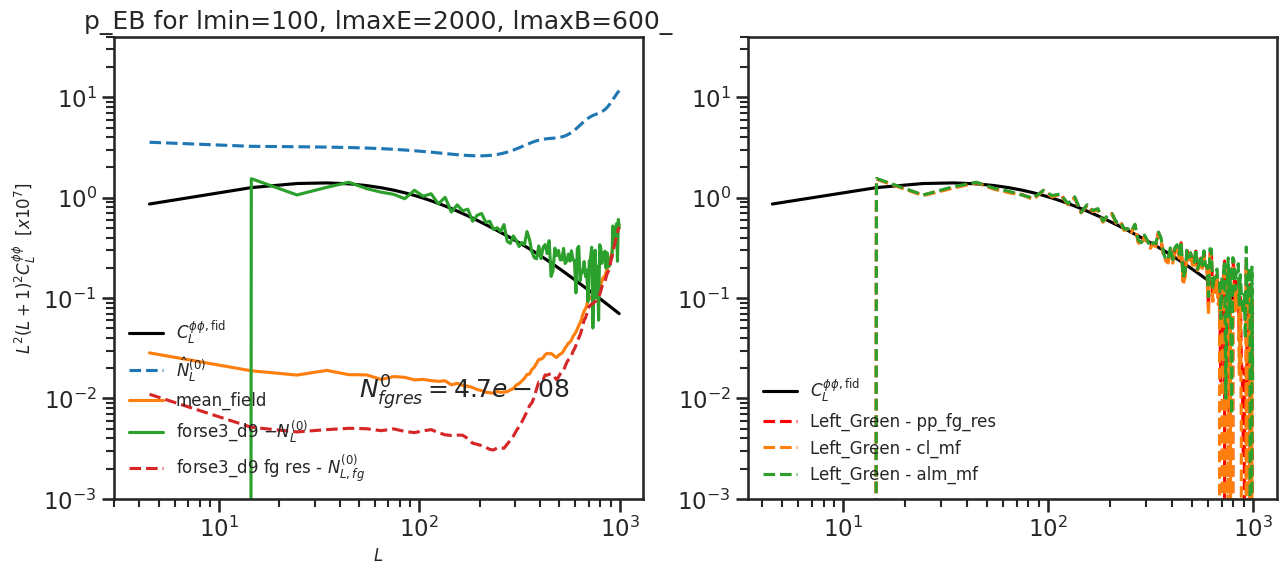

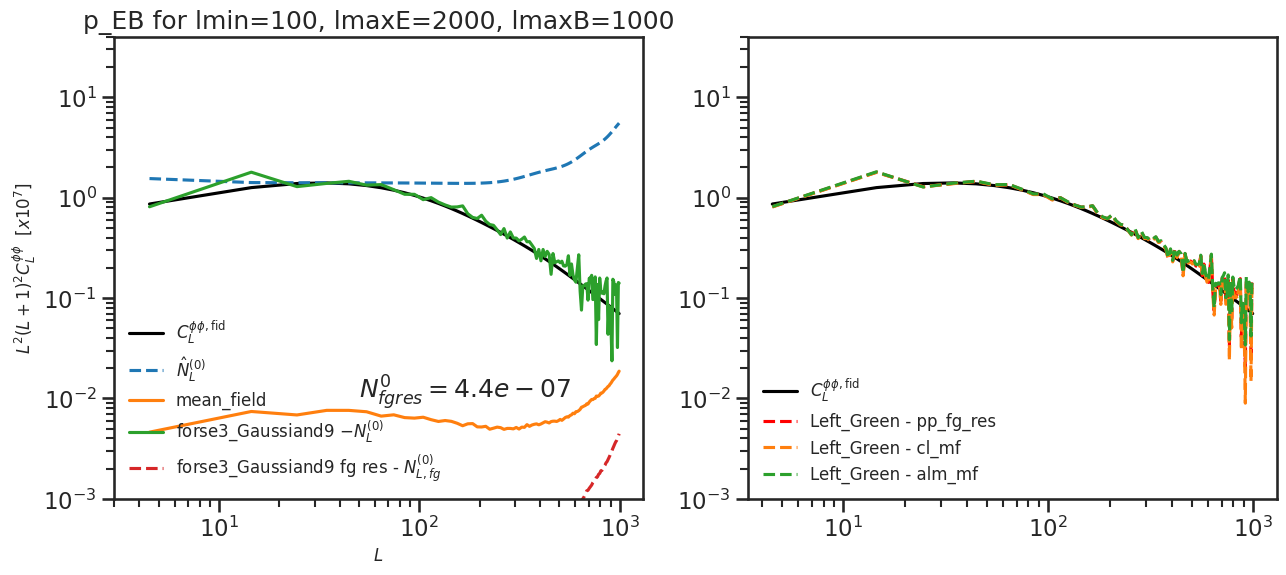

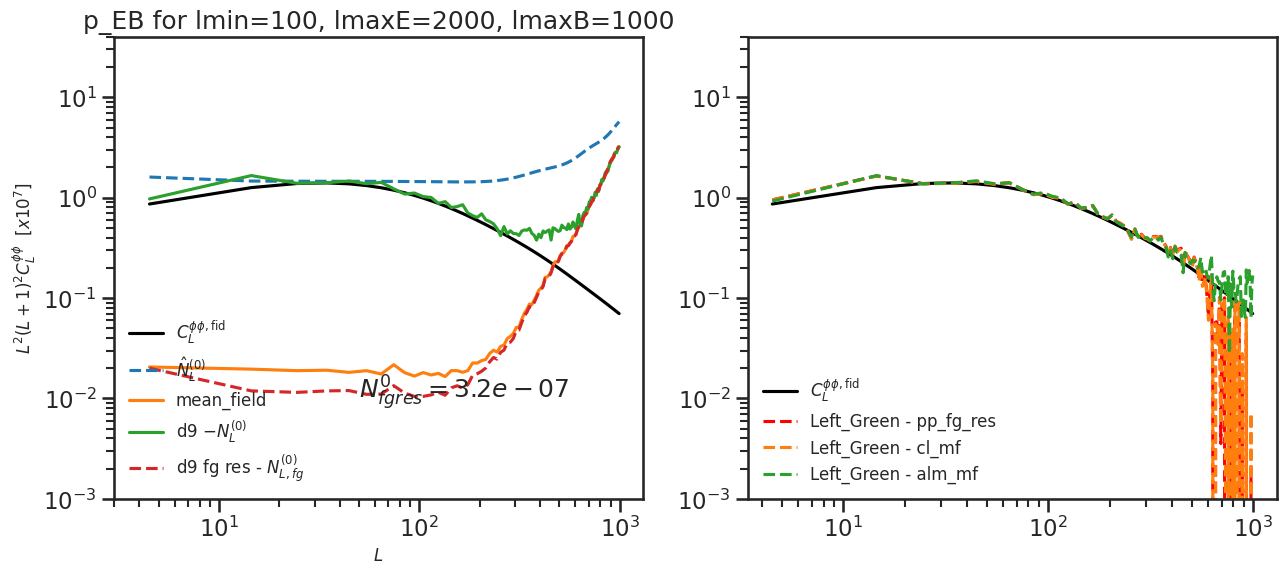

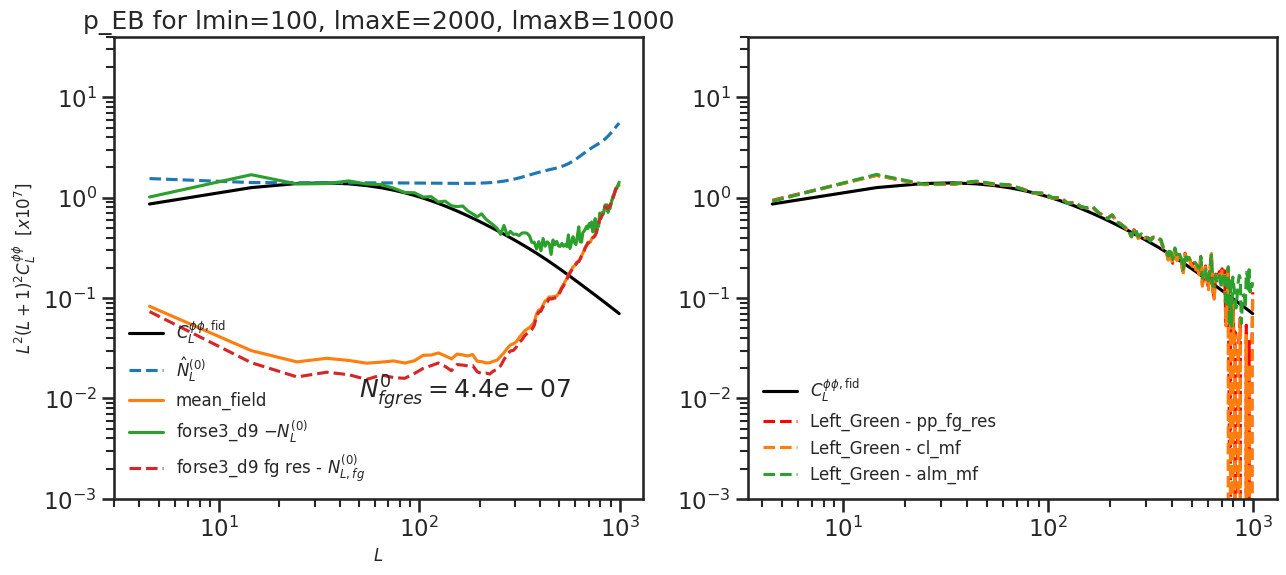

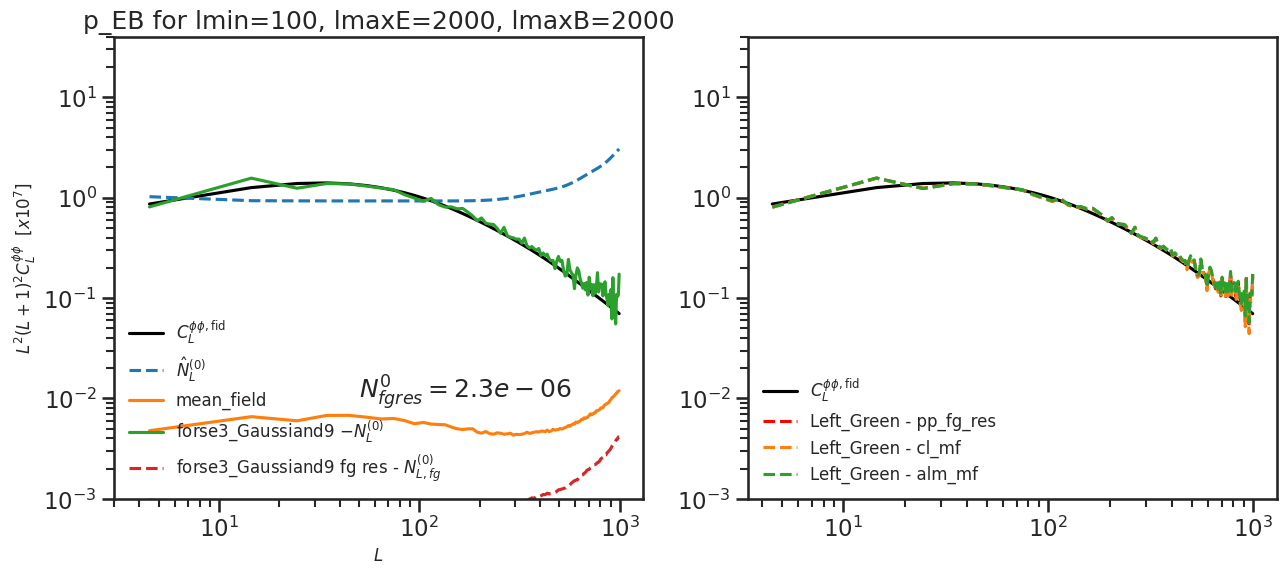

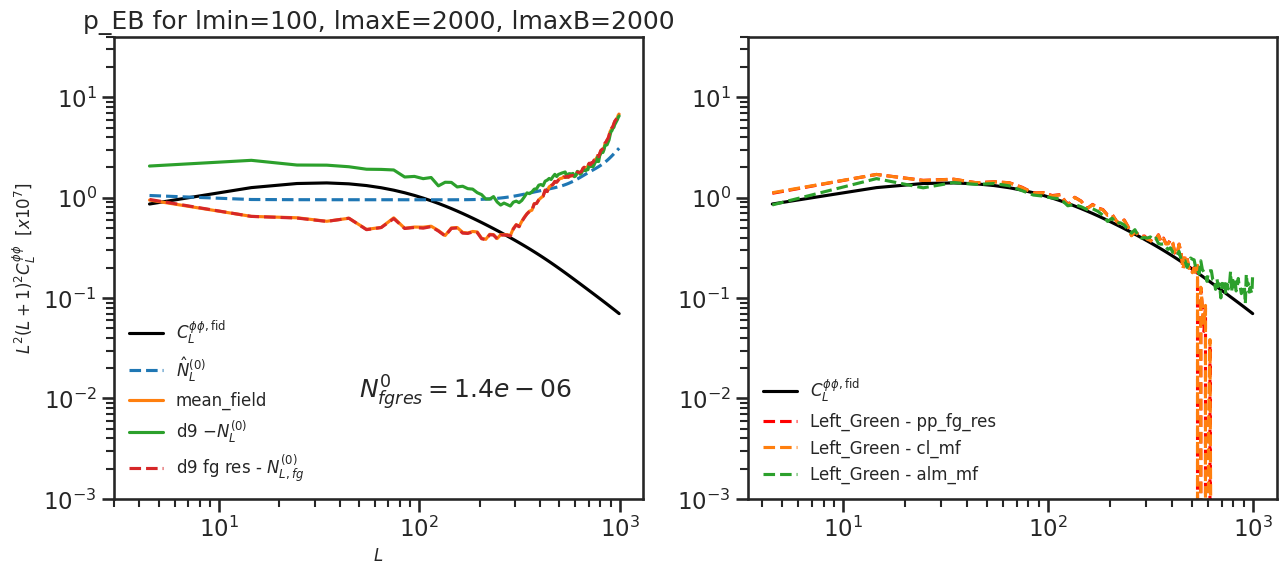

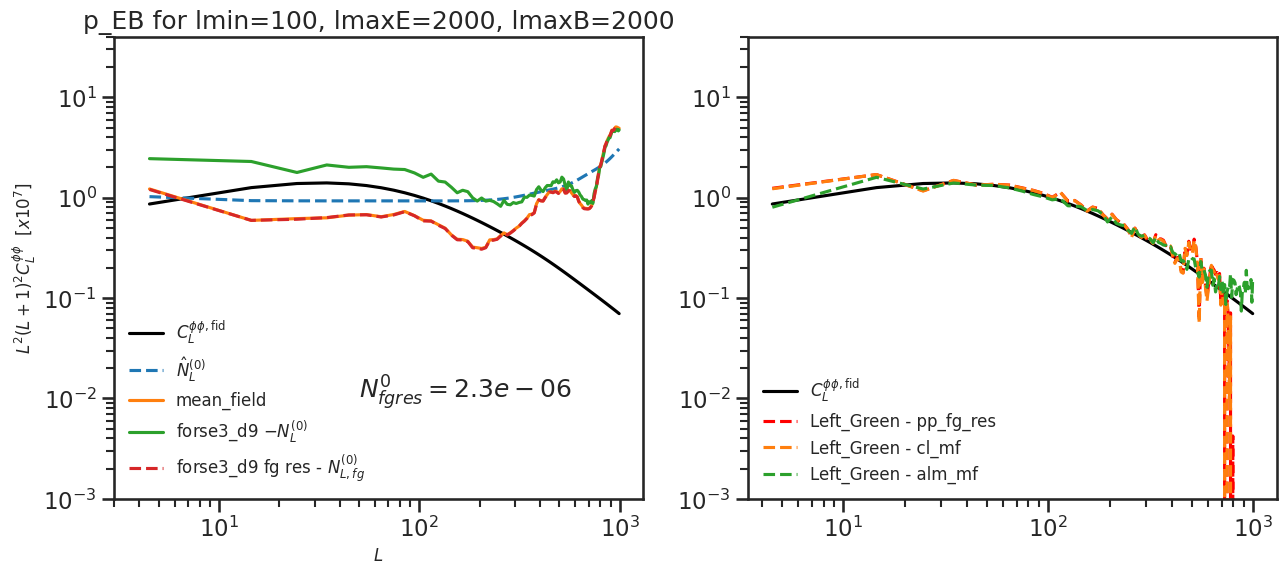

In [35]:
mfs = []
phi_fgs = []

lmin_ivf = 100
lmax_ivf=2000

lmax_Bmode= 600
for case in cases:
    d9_res = run_qe(['p_eb'], [case], lmin_ivf = lmin_ivf, lmax_ivf=lmax_ivf, lmax_qlm = 1000, mf = None, nsim = 1, lmax_Bmode= lmax_Bmode, old_dir= False, from_fg_res=True, compare_mf=True)
    mfs.append(d9_res[2])
    phi_fgs.append(d9_res[5])
    plot_lensing(1000, d9_res, return_binned = False, qe_key = 'p_EB', add_foreground = case, conf = 'lmin=%s, lmaxE=%s, lmaxB=%s_'%(lmin_ivf, lmax_ivf, lmax_Bmode), from_fg_res=True)

lmax_Bmode= 1000
for case in cases:
    
    d9_res_1000 = run_qe(['p_eb'], [case], lmin_ivf = lmin_ivf, lmax_ivf=lmax_ivf, lmax_qlm = 1000, mf = None, nsim = 1, lmax_Bmode= lmax_Bmode, old_dir= False, from_fg_res=True, compare_mf=True)
    mfs.append(d9_res_1000[2])
    phi_fgs.append(d9_res_1000[5])
    plot_lensing(1000, d9_res_1000, return_binned = False, qe_key = 'p_EB', add_foreground = case, conf = 'lmin=%s, lmaxE=%s, lmaxB=%s'%(lmin_ivf, lmax_ivf, lmax_Bmode), from_fg_res=True)

lmax_Bmode= 2000
for case in cases:
    
    d9_res_2000 = run_qe(['p_eb'], [case], lmin_ivf = lmin_ivf, lmax_ivf=lmax_ivf, lmax_qlm = 1000, mf = None, nsim = 1, lmax_Bmode= lmax_Bmode, old_dir= False, from_fg_res=True, compare_mf=True)
    mfs.append(d9_res_2000[2])
    phi_fgs.append(d9_res_2000[5])
    plot_lensing(1000, d9_res_2000, return_binned = False, qe_key = 'p_EB', add_foreground = case, conf = 'lmin=%s, lmaxE=%s, lmaxB=%s'%(lmin_ivf, lmax_ivf, lmax_Bmode), from_fg_res=True)

In [365]:
colors = sns.color_palette()

In [36]:
len(mfs)

9

In [53]:
def plot_fg_bias(cases_ori, ells, lmax_qlm, mfs, phi_fgs, qe_key = 'p_p', conf = 'lmin = 100'):
    
    '''
    lmax_qlm
    results: output from `run_qe`with nsim == 1
    ells, results_phi, results_mf, results_n0
    '''
    cases = cases_ori + cases_ori+ cases_ori 
    bw = 10
    
    ell_binned, cl_pp = bin_cell(cl_unl['pp'][ells] *  w(ells), lmax = lmax_qlm, bins=bw, ell_2=False)

    plt.figure(figsize = (24, 6))
   
    for i in range(len(cases)):
    
        _, phi_fg_binned = bin_cell(phi_fgs[i][0], lmax = lmax_qlm, bins=bw, ell_2=False)
        _, mf_binned =  bin_cell(mfs[i][0], lmax = lmax_qlm, bins=bw, ell_2=False)
        
    # plt.title('%s for %s, lmin = %s, lmax = %s'%(qe_key, add_foreground, lmin_qlm, lmax_qlm))
    

    # label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
    
        plt.subplot(1, 3, i//3 +1)
        
        plt.loglog(ell_binned, mf_binned[0], label = 'mean_field_%s'%cases[i], ls = '--')
        plt.loglog(ell_binned, phi_fg_binned[0], label = r'%s fg res - $N_{L, fg}^{(0)}$'%cases[i], ls = '-')

        
    lmaxBs = [600, 1000, 2000]
    for j in range(3):
        plt.subplot(1, 3, j+1)
        plt.title('%s for lmin=100, lmaxE=2000, lmaxB=%s'%(qe_key, lmaxBs[j]))
        plt.loglog(ell_binned, cl_pp[0], c='k')#, label=r'$C_L^{\phi\phi, \rm fid}$'
        plt.xlabel('$L$', fontsize=12)
        plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
        plt.ylim(1e-5,4e1)
        plt.xlim(3, )
        if j == 2:
            plt.legend(fontsize=12, loc='lower left', frameon = False, ncol = 2)

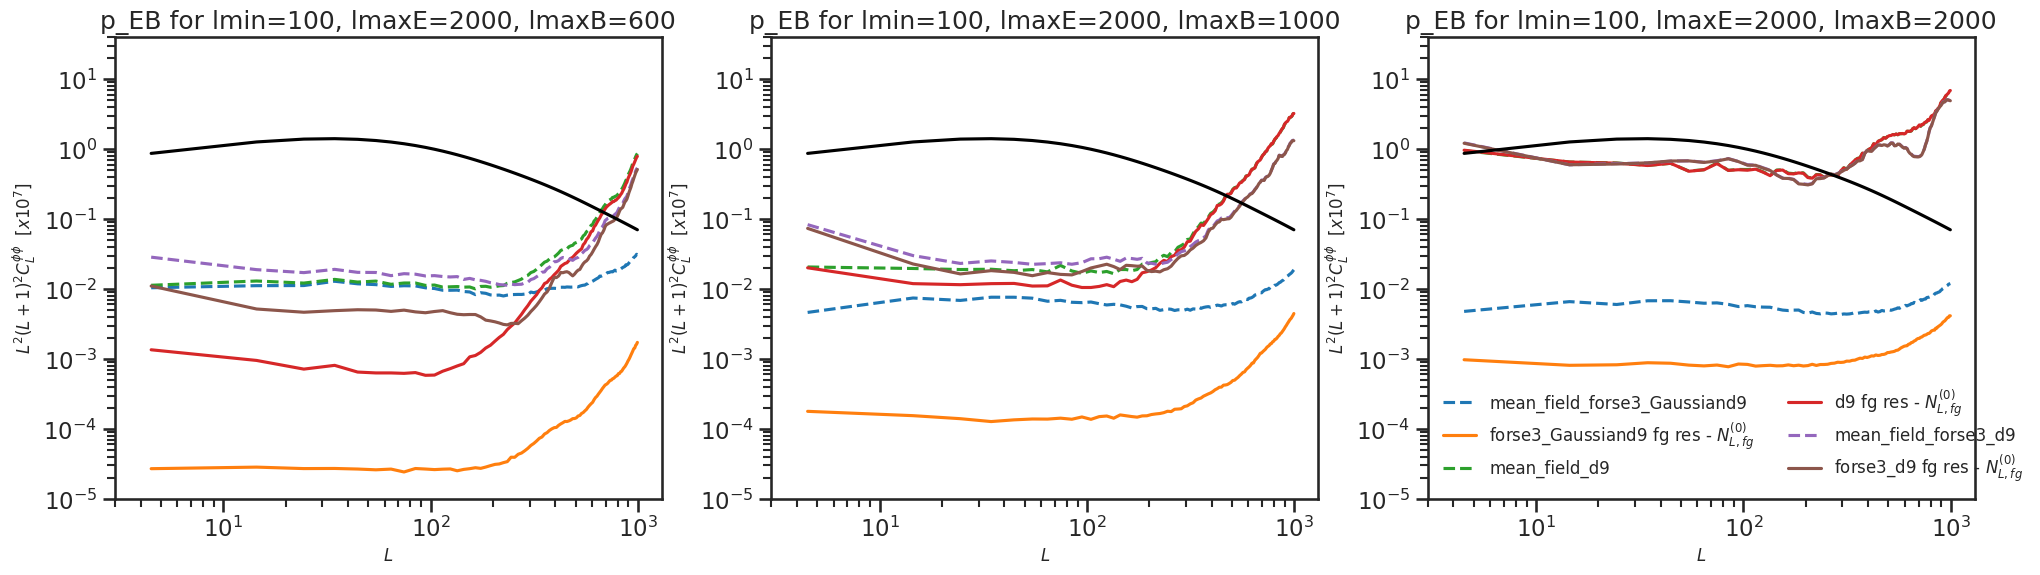

In [54]:
plot_fg_bias(cases, ells, 1000, mfs, phi_fgs,  qe_key = 'p_EB', conf = 'lmin=%s, lmaxE=%s, lmaxB=%s_'%(lmin_ivf, lmax_ivf, lmax_Bmode))

In [56]:
cases

['forse3_Gaussiand9', 'd9', 'forse3_d9']

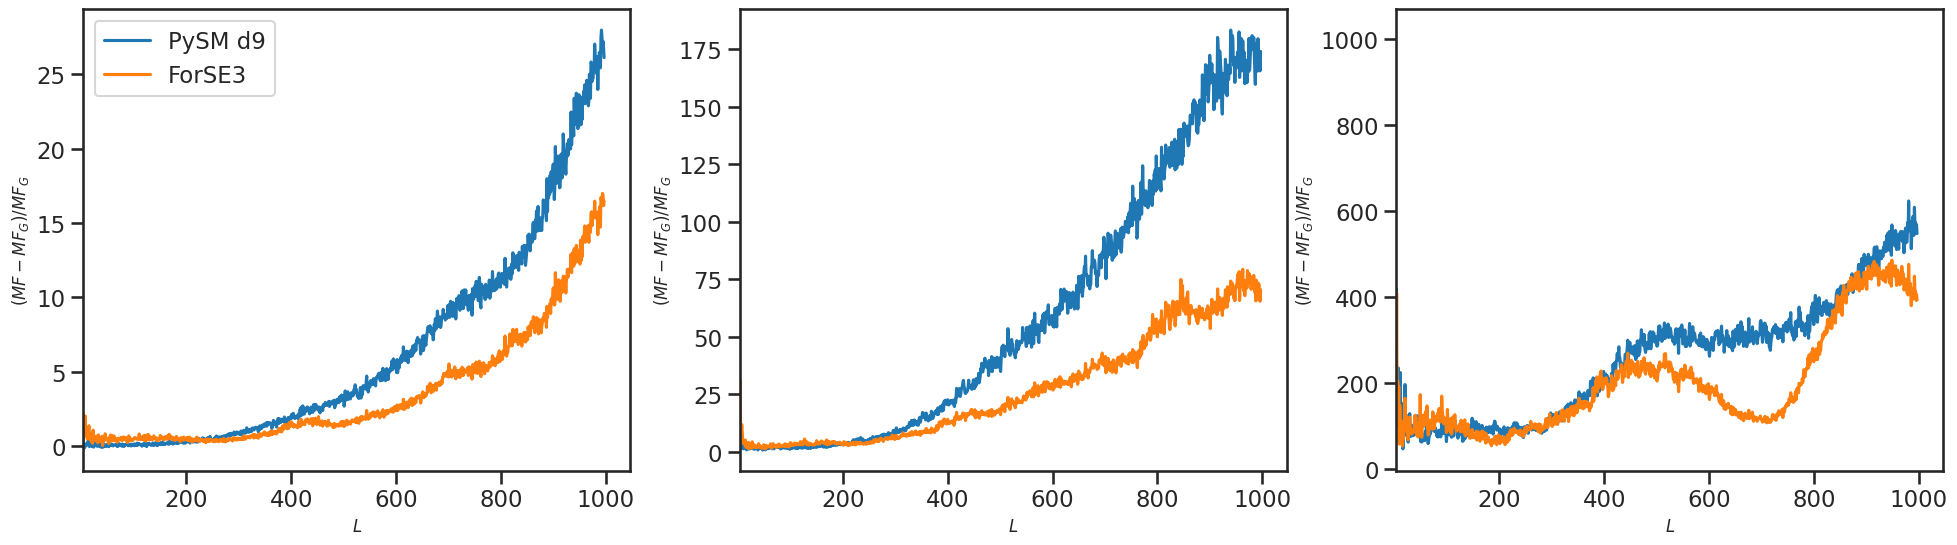

In [73]:
plt.figure(figsize = (24, 6))
for i in range(3):
    mf_g = mfs[i*3][0]
    mf_p = mfs[i*3 + 1][0]
    mf_f = mfs[i*3 + 2][0]
    
    plt.subplot(1, 3, i+1)
    plt.plot((mf_p-mf_g)/mf_g, label = 'PySM d9')
    plt.plot((mf_f-mf_g)/mf_g, label = 'ForSE3')
    plt.xlim(3, )
    plt.xlabel('$L$', fontsize=12)
    plt.ylabel('$(MF - MF_{G})/MF_{G}$', fontsize=12)
    if i == 0:
        plt.legend()